In [2]:
import h5py, numpy as np, os, sys
sys.path.append("..")

from src.utils import _get_synthetic_data
from src.model_zoo import deep_cnn, shallow_cnn

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import callbacks as tfkc

from logomaker import Logo
import pandas as pd

import inspect 
from inspect import getargspec

In [21]:
format(1e-6, ".0e")

'1e-06'

In [29]:
l2 = 1e-4
print("l2="+format(l2, ".0e"))

l2=1e-04


In [27]:
format(l2, ".0e")

'1e-04'

In [16]:
data = np.eye(4)[np.random.randint(0,4,(20,))].astype(np.int32)
seq = pd.DataFrame(data=data, columns=list('ACGT'))

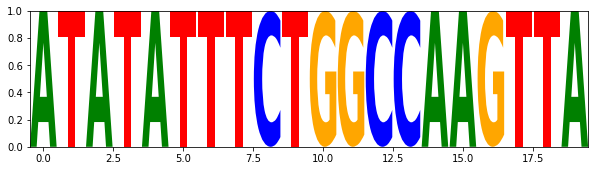

In [17]:
Logo(seq)

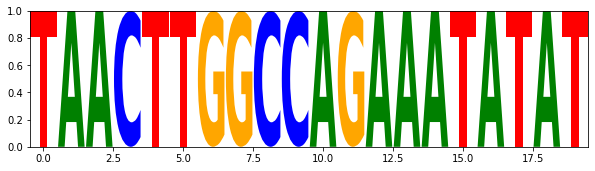

In [21]:
seq = pd.DataFrame(data=data[::-1, ::-1], columns=list('ACGT'))
Logo(seq)

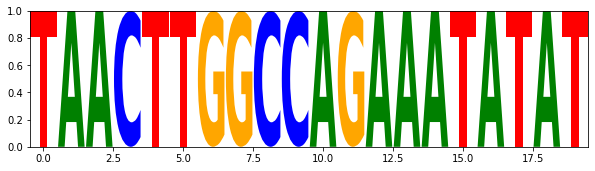

In [24]:
Logo(
    pd.DataFrame(data=data[::-1,:][:,::-1], columns=list('ACGT'))
)

In [32]:
class EarlyStoppingCheckpoint(tfkc.EarlyStopping):
    """
    This callback checkpoints the model at the early stopping epoch 
    without actually stopping. We can use this to put a marker on 
    the exact epoch where model training would have stoppedm *without* 
    actually stopping. 
    
    This callback takes the same arguments as the keras.callbacks.EarlyStopping
    callback. 
    
    Documentation for the EarlyStopping callback follows.
    ------------------------------------------------------
    
    """
    __doc__  = __doc__ + tfkc.EarlyStopping.__doc__
    
    def on_epoch_end(self, epoch, logs=None):
        if self.stopped_epoch > 0:  ## the early stopping epoch has already been logged 
            return
        else:
            current = self.get_monitor_value(logs) ## get current value of monitored value. 
            if current is None:  ## the requested monitor quantity is not in the logs
                return
            
            self.wait += 1
            if self._is_improvement(current, self.best):
                ## update the best seen value of the monitored metric.
                self.best = current
                
                # get the best weights of the model 
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()
            
            # Only restart wait if we beat both the baseline and our previous best.
            if self.baseline is None or self._is_improvement(current, self.baseline):
                self.wait = 0
        
            # check to see if we have waited long enough ; if true, this is where the training would have stopped
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.restore_best_weights and self.best_weights is not None:
                    # checkpoint the model 
                    self.model.save("early_stopping_ckpt")
                    
                    if self.verbose:
                        print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))
                        print('The best model weights from early stopping are checkpointed as - early_stopping_ckpt')

In [54]:
# get data 
datadir = os.path.abspath("../data/")
traindata, validdata, testdata, model_test = _get_synthetic_data(datadir)

# set up model
model = get_model(bn=True, dropout1=0.2, dropout2=0.5)

# compile model
model.compile(
            loss=tfk.losses.BinaryCrossentropy(), 
            optimizer=tfk.optimizers.Adam(1e-3),
            metrics=[tfk.metrics.AUC(curve='PR', name='aupr'), tfk.metrics.AUC(curve='ROC', name='auroc')]
)

# fit model
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
                                        monitor='val_auroc',
                                        factor=0.2,
                                        patience=4,
                                        min_lr=1e-7,
                                        mode='max',
                                        verbose=1
                                            )
esckpt_callback = EarlyStoppingCheckpoint(
                                    monitor='val_auroc',
                                    patience=4,
                                    verbose=1,
                                    mode='max',
                                    restore_best_weights=True
                                        )
callbacks = [reduce_lr, esckpt_callback]
traindata = tf.data.Dataset.from_tensor_slices(traindata)
validdata = tf.data.Dataset.from_tensor_slices(validdata)
model.fit(
        traindata.shuffle(10000).batch(32), 
        validation_data=validdata.shuffle(10000).batch(64),
        epochs=100,
        callbacks=callbacks
        )

Epoch 1/100
438/438 [==============================] - 8s 14ms/step - loss: 0.6494 - aupr: 0.6874 - auroc: 0.7133 - val_loss: 0.5992 - val_aupr: 0.7843 - val_auroc: 0.7999
Epoch 2/100
438/438 [==============================] - 6s 14ms/step - loss: 0.5434 - aupr: 0.7859 - auroc: 0.8013 - val_loss: 0.5802 - val_aupr: 0.8382 - val_auroc: 0.8443
Epoch 3/100
438/438 [==============================] - 6s 14ms/step - loss: 0.4989 - aupr: 0.8253 - auroc: 0.8366 - val_loss: 0.5568 - val_aupr: 0.8703 - val_auroc: 0.8716
Epoch 4/100
438/438 [==============================] - 6s 13ms/step - loss: 0.4720 - aupr: 0.8482 - auroc: 0.8561 - val_loss: 0.4817 - val_aupr: 0.8902 - val_auroc: 0.8921
Epoch 5/100
438/438 [==============================] - 6s 14ms/step - loss: 0.4406 - aupr: 0.8722 - auroc: 0.8768 - val_loss: 0.4633 - val_aupr: 0.9026 - val_auroc: 0.9078
Epoch 6/100
438/438 [==============================] - 6s 14ms/step - loss: 0.4152 - aupr: 0.8884 - auroc: 0.8919 - val_loss: 0.4480 - val_a

Epoch 93/100
438/438 [==============================] - 7s 16ms/step - loss: 0.1431 - aupr: 0.9865 - auroc: 0.9871 - val_loss: 0.1838 - val_aupr: 0.9815 - val_auroc: 0.9836
Epoch 94/100
438/438 [==============================] - 7s 16ms/step - loss: 0.1349 - aupr: 0.9883 - auroc: 0.9888 - val_loss: 0.1833 - val_aupr: 0.9816 - val_auroc: 0.9836
Epoch 95/100
438/438 [==============================] - 7s 16ms/step - loss: 0.1392 - aupr: 0.9881 - auroc: 0.9882 - val_loss: 0.1844 - val_aupr: 0.9817 - val_auroc: 0.9837
Epoch 96/100
438/438 [==============================] - 7s 16ms/step - loss: 0.1387 - aupr: 0.9875 - auroc: 0.9879 - val_loss: 0.1817 - val_aupr: 0.9816 - val_auroc: 0.9837
Epoch 97/100
438/438 [==============================] - 7s 16ms/step - loss: 0.1350 - aupr: 0.9886 - auroc: 0.9886 - val_loss: 0.1865 - val_aupr: 0.9816 - val_auroc: 0.9836
Epoch 98/100
438/438 [==============================] - 7s 16ms/step - loss: 0.1426 - aupr: 0.9868 - auroc: 0.9872 - val_loss: 0.1838 -

In [47]:
help(esckpt_callback)

Help on EarlyStoppingCheckpoint in module __main__ object:

class EarlyStoppingCheckpoint(keras.callbacks.EarlyStopping)
 |  EarlyStoppingCheckpoint(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
 |  
 |    This callback checkpoints the model at the early stopping epoch 
 |    without actually stopping. We can use this to put a marker on 
 |    the exact epoch where model training would have stoppedm *without* 
 |    actually stopping. 
 |    
 |    This callback takes the same arguments as the keras.callbacks.EarlyStopping
 |    callback. 
 |    
 |    Documentation for the EarlyStopping callback follows.
 |    ------------------------------------------------------
 |    
 |    Stop training when a monitored metric has stopped improving.
 |  
 |  Assuming the goal of a training is to minimize the loss. With this, the
 |  metric to be monitored would be `'loss'`, and mode would be `'min'`. A
 |  `model.fit()` training loo

In [11]:
file = h5py.File("data.h5", "w",)
file.create_dataset(name='x', data=x, compression='gzip')
file.create_dataset(name='y', data=y, compression='gzip')
file.close()
del file

In [15]:
file = h5py.File("data.h5", "r")
print(file.keys())
print(file['x'].shape)
print(file['y'].shape)
print(file['x'][:])
print(file['y'][:])
file.close()

<KeysViewHDF5 ['x', 'y']>
(3,)
(4,)
[ 0.39355985 -0.11586729  0.19599572]
[-1.69105083  1.95044657  0.91279094 -0.70167148]


In [16]:
help(file.create_dataset)

Help on method create_dataset in module h5py._hl.group:

create_dataset(name, shape=None, dtype=None, data=None, **kwds) method of h5py._hl.files.File instance
    Create a new HDF5 dataset
    
    name
        Name of the dataset (absolute or relative).  Provide None to make
        an anonymous dataset.
    shape
        Dataset shape.  Use "()" for scalar datasets.  Required if "data"
        isn't provided.
    dtype
        Numpy dtype or string.  If omitted, dtype('f') will be used.
        Required if "data" isn't provided; otherwise, overrides data
        array's dtype.
    data
        Provide data to initialize the dataset.  If used, you can omit
        shape and dtype arguments.
    
    Keyword-only arguments:
    
    chunks
        (Tuple or int) Chunk shape, or True to enable auto-chunking. Integers can
        be used for 1D shape.
    
    maxshape
        (Tuple or int) Make the dataset resizable up to this shape. Use None for
        axes you want to be unlimited.

In [35]:
file = open("commands.txt", "w")
for l2 in ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6']:
    for factor in ['1', '4', '8']:
        for type in ['deep', 'shallow']:
            file.write(f"python task1_sub5_1_train.py --batch 32 --epochs 100 --start_trial 1 --end_trial 5 --lr 1e-3 --track_saliency --track_sg --track_intgrad --factor {factor} --type {type} --l2 {l2} \n")
for d1 in ['0.1', '0.2', '0.3', '0.5', '0.75']:
    for factor in ['1', '4', '8']:
        for type in ['deep', 'shallow']:
            file.write(f"python task1_sub5_2_train.py --batch 32 --epochs 100 --start_trial 1 --end_trial 5 --lr 1e-3 --track_saliency --track_sg --track_intgrad --factor {factor} --type {type} --dropout1 {d1} \n")
file.close()